# Proyecto 3 Minería de datos: Clustering de partición y asociación

Importar módulos

In [88]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from apyori import apriori
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score, v_measure_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [65]:
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            pass
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [37]:
def calculate_purity(conf_matrix):
    return np.sum(np.amax(conf_matrix, axis=0)) / np.sum(conf_matrix)

Leer el dataset

In [38]:
df = pd.read_csv("set_Sebastian_Bustamante_clean.csv")
X = df
y = df["booking_status"]

## K-Means - eliminar columna de etiqueta

In [55]:
X_nolabels = X.drop(columns=["booking_status"]) # La columna de la etiqueta la tenemos desde antes

In [56]:
kmeans = KMeans(n_clusters=3, random_state=0) 

kmeans.fit(X_nolabels)

KMeans(n_clusters=3, random_state=0)

In [57]:
kmeans.cluster_centers_

array([[ 0.49653647, -0.24861178,  0.23335591,  0.27518951, -0.14734527,
         0.11835293,  0.43479946, -0.20743089,  0.14927174,  0.0810409 ,
         0.07431797,  0.5669086 , -0.13553369, -0.05463565, -0.07502443,
         0.41754579,  0.59558506],
       [-0.33112491, -0.24487908, -0.17005717, -0.19646028,  0.14924814,
        -0.09509943, -0.43266706,  0.16584342, -0.13340696, -0.05011981,
        -0.06320407, -0.45155181,  0.10752324,  0.04355241,  0.05970675,
        -0.44625879, -0.45431379],
       [-0.01600221,  3.28012202,  0.10752776,  0.09427228, -0.40151052,
         0.12505172,  1.1230824 , -0.21253993,  0.26499413, -0.03387608,
         0.10631415,  0.56734069, -0.13219879, -0.05495004, -0.0746719 ,
         1.32360971,  0.43605286]])

In [58]:
kmeans.labels_

array([1, 0, 1, ..., 1, 1, 2], dtype=int32)

In [59]:
kmeans.inertia_

719108.7857379676

In [63]:
conf_matrix = confusion_matrix(y, kmeans.labels_)
print(f"Matriz:\n {conf_matrix}")
purity = calculate_purity(conf_matrix)
print(f"Pureza (custom): {purity}")
ari = adjusted_rand_score(y, kmeans.labels_)
print(f"ARI: {ari}")
v_measure = v_measure_score(y, kmeans.labels_)
print(f"V-measure: {v_measure}")

Matriz:
 [[ 8247 14149  1994]
 [10049 12929  1412]
 [    0     0     0]]
Pureza (custom): 0.5369413694136942
ARI: 0.004242753840174083
V-measure: 0.004334351833827549


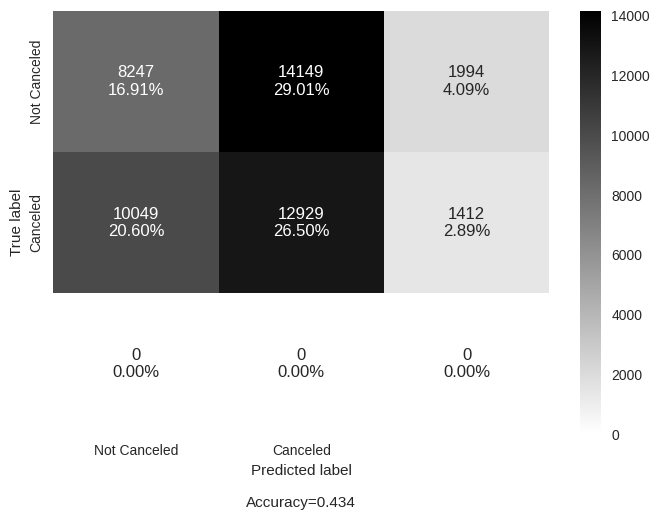

In [67]:
labels = ["Cluster 0", "Cluster 1"]
categories = ["Not Canceled", "Canceled"]
make_confusion_matrix(conf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap="binary")

### Pruebas con PCA

In [26]:
pca = PCA()
X_pca = pca.fit_transform(X_nolabels)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

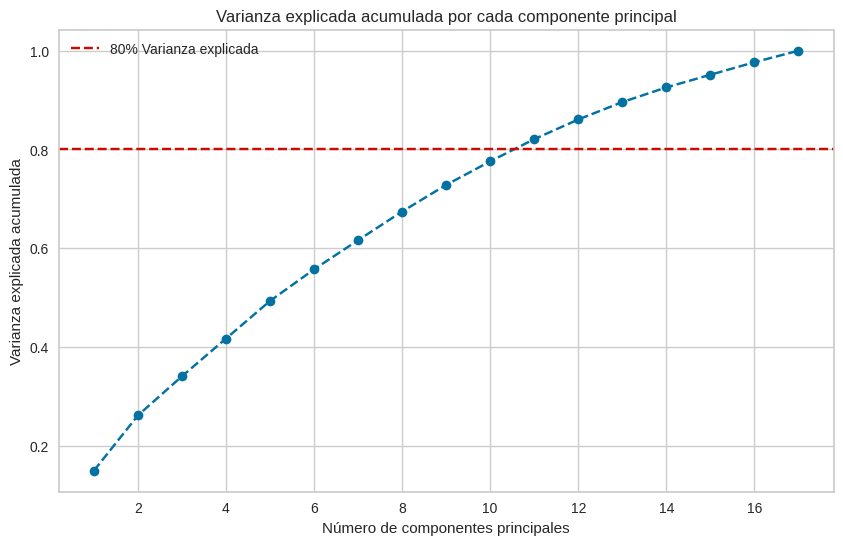

In [27]:
# Gráfico de la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Varianza explicada acumulada por cada componente principal')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Varianza explicada')
plt.legend(loc='best')
plt.show()

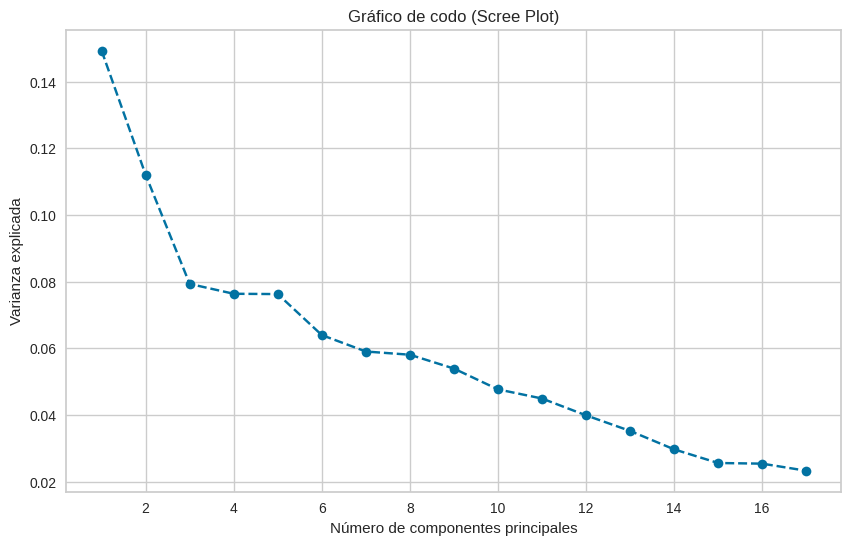

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Gráfico de codo (Scree Plot)')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada')
plt.grid(True)
plt.show()

PCA a 2 dimensiones y graficar

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_nolabels)

In [30]:
print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)

Varianza explicada por cada componente: [0.14923106 0.11200123]


In [31]:
# Aplicar KMeans
kmeans = KMeans(n_clusters=2, random_state=0)  # Elegir el número de clusters adecuado
kmeans.fit(X_pca)

conf_matrix = confusion_matrix(y, kmeans.labels_)
print(f"Matriz:\n {conf_matrix}")
purity = calculate_purity(conf_matrix)
print(f"Pureza (custom): {purity}")
ari = adjusted_rand_score(y, kmeans.labels_)
print(f"ARI: {ari}")
v_measure = v_measure_score(y, kmeans.labels_)
print(f"V-measure: {v_measure}")

/home/seba/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Matriz:
 [[17574  6816]
 [18219  6171]]
Pureza (custom): 0.5132226322263223
ARI: 0.0006833434038376803
V-measure: 0.0007034754394428104


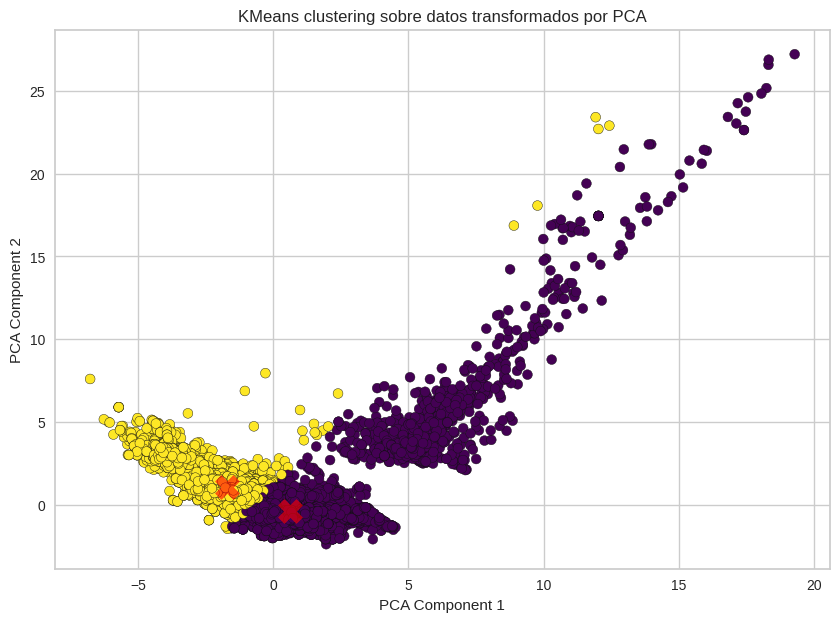

In [32]:
# Obtener los centros de los clusters y las etiquetas
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Visualizar los resultados
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.6, marker='X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans clustering sobre datos transformados por PCA')
plt.show()

De nuevo PCA pero ahora con 3 clusters

/home/seba/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


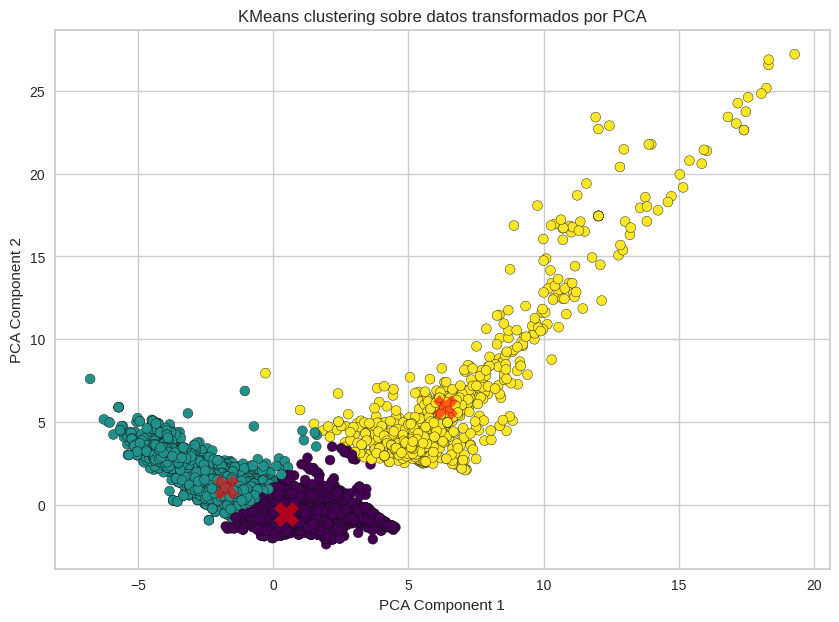

In [33]:
# Aplicar KMeans
kmeans = KMeans(n_clusters=3, random_state=0)  # Elegir el número de clusters adecuado
kmeans.fit(X_pca)

# Obtener los centros de los clusters y las etiquetas
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# Visualizar los resultados
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=300, alpha=0.6, marker='X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans clustering sobre datos transformados por PCA')
plt.show()

Técnica del codo para saber numero óptimo de clusters

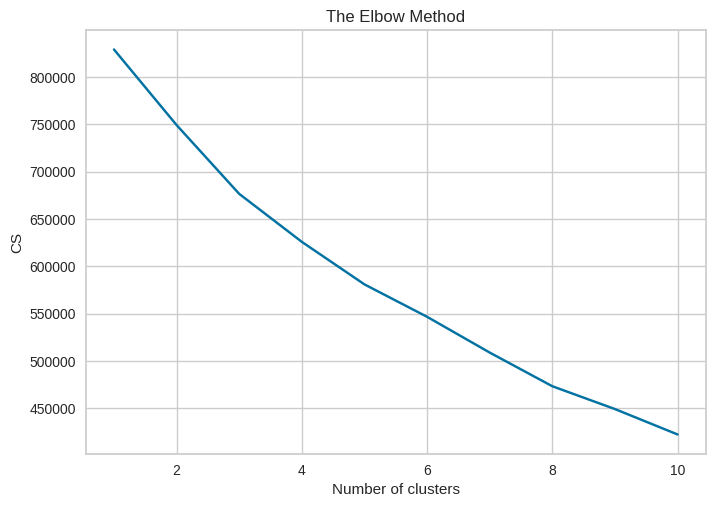

In [34]:
cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_nolabels)
    cs.append(kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

Otro elbow method

Elbow Method to determine the number of clusters to be formed:


/home/seba/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/seba/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/seba/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/seba/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

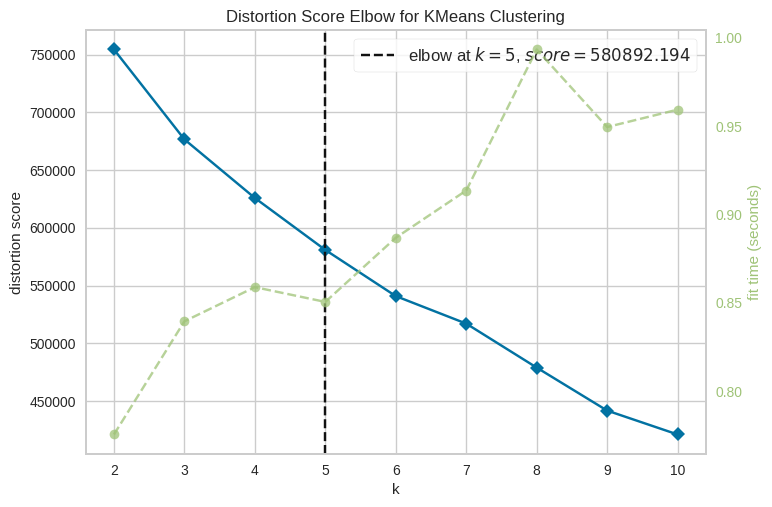

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(X_nolabels)
Elbow_M.show()

## Clustering Jerárquico

In [36]:
X_sample, _, _, _ = train_test_split(df, df.index, test_size=0.7, stratify=df.iloc[:, 17], random_state=0)
X_sample = X_sample.drop(columns=["booking_status"])
Z = linkage(X_sample, method='ward')

Mostrar el dendrograma

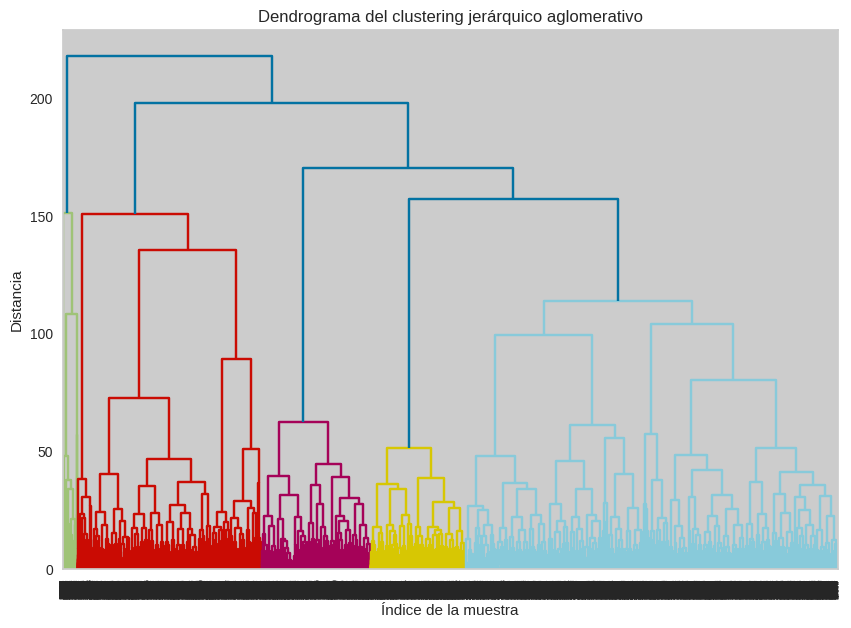

In [37]:
# Crear el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrograma del clustering jerárquico aglomerativo')
plt.xlabel('Índice de la muestra')
plt.ylabel('Distancia')
plt.show()

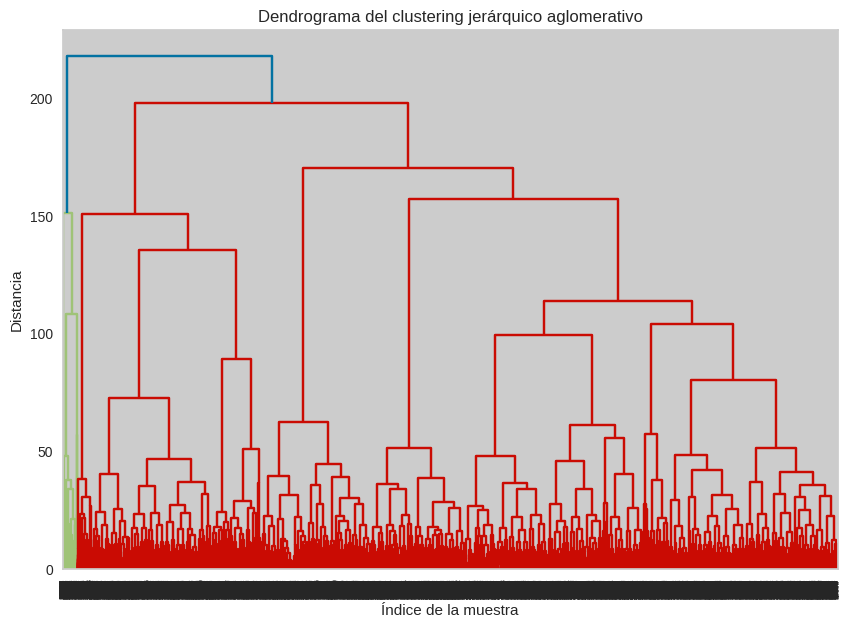

In [38]:
# Crear el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z, color_threshold=200)
plt.title('Dendrograma del clustering jerárquico aglomerativo')
plt.xlabel('Índice de la muestra')
plt.ylabel('Distancia')
plt.show()

## Reglas de asociación

El algoritmo se demoraba mucho con el set de datos completo, así que se extrae realiza un muestreo del 30% de la data, se asegura que el muestreo sea balanceado.

In [263]:
dataset = pd.read_csv("set_Sebastian_Bustamante.csv")
dataset = dataset.drop(columns=["Booking_ID"])

In [264]:
X_sample, _, _, _ = train_test_split(dataset, dataset.index, test_size=0.8, stratify=dataset.iloc[:, 17], random_state=0)

In [265]:
X_sample.head()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
30977             2               0                     0                  3   
3745              2               0                     0                  2   
32932             2               0                     0                  1   
15583             3               0                     2                  1   
1468              1               0                     0                  3   

      type_of_meal_plan  required_car_parking_space room_type_reserved  \
30977       Meal Plan 1                           0        Room_Type 1   
3745        Meal Plan 1                           1        Room_Type 1   
32932      Not Selected                           0        Room_Type 1   
15583       Meal Plan 1                           0        Room_Type 1   
1468        Meal Plan 1                           0        Room_Type 1   

       lead_time  arrival_year  arrival_month  arrival_date  \
30977        204          2018              5             5   
3745          33          2018              9            15   
32932          6          2018              3             3   
15583         62          2018              5             1   
1468          14          2017              9            15   

      market_segment_type  repeated_guest  no_of_previous_cancellations  \
30977             Offline               0                             0   
3745               Online               0                             0   
32932              Online               0                             0   
15583              Online               0                             0   
1468               Online               0                             0   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
30977                                     0              100.00   
3745                                      0              117.33   
32932                                     0               87.00   
15583                                     0              159.30   
1468                                      0              114.00   

       no_of_special_requests booking_status  
30977                       0       Canceled  
3745                        2   Not_Canceled  
32932                       2   Not_Canceled  
15583                       0       Canceled  
1468                        1   Not_Canceled

Volver a discretizar la data

Se vuelve a hacer discreta la data, pasando las variables numericas a categóricas mediante binning.

In [266]:
X_sample["no_of_adults"] = pd.cut(X_sample["no_of_adults"], bins = [-1, 2, 4], labels=["Low adults", "High Adults"])

X_sample["no_of_children"] = pd.cut(X_sample["no_of_children"], bins = [-1, 3, 9], labels=["Low Children", "High Children"])

X_sample["no_of_weekend_nights"] = pd.cut(X_sample["no_of_weekend_nights"], bins=[-1, 2, 6], labels=["Main Work", "Main Vacation"])

X_sample["no_of_week_nights"] = pd.cut(X_sample["no_of_week_nights"], bins=[-1, 3, 15], labels=["Short Stay", "Long Stay"])

X_sample["required_car_parking_space"] = X_sample["required_car_parking_space"].replace({1:"Required PS", 0:"No PS"})

X_sample["lead_time"] = pd.cut(X_sample["lead_time"], bins=[-1, 57, 443], labels=["Not Planned", "Planned"])

X_sample["arrival_year"] = X_sample["arrival_year"].replace({2017:"2017", 2018:"2018"})

X_sample["arrival_month"] = pd.cut(X_sample["arrival_month"], bins=[-1, 6, 12], labels=["winter", "summer"])

X_sample["arrival_date"] = pd.cut(X_sample["arrival_date"], bins=[1, 15, 31], labels=["FH month", "SH month"])

X_sample["repeated_guest"] = X_sample["repeated_guest"].replace({0:"Not repeated guest", 1:"Repeated guest"})

X_sample["no_of_previous_cancellations"] = pd.cut(X_sample["no_of_previous_cancellations"], bins=[-1, 3, 13], labels=["Trustworthy", "Not Trustworthy"])

X_sample["no_of_previous_bookings_not_canceled"] = pd.cut(X_sample["no_of_previous_bookings_not_canceled"], bins=[-1, 5, 57], labels=["Low not cancel", "High not cancel"])

X_sample["avg_price_per_room"] = pd.cut(X_sample["avg_price_per_room"], bins=[-1, 99, 120, 377], labels=['cheap', 'medium', 'expensive'])

X_sample["no_of_special_requests"] = pd.cut(X_sample["no_of_special_requests"], bins=[-1, 1, 5], labels=["low sp requests", "high sp requests"])


In [267]:
X_sample = pd.get_dummies(X_sample, columns=X_sample.columns, prefix="is")

In [268]:
X_sample

is_Low adults  is_High Adults  is_Low Children  is_High Children  \
30977           True           False             True             False   
3745            True           False             True             False   
32932           True           False             True             False   
15583          False            True             True             False   
1468            True           False             True             False   
...              ...             ...              ...               ...   
20091           True           False             True             False   
21279           True           False             True             False   
3671           False            True             True             False   
22084           True           False             True             False   
29035           True           False             True             False   

       is_Main Work  is_Main Vacation  is_Short Stay  is_Long Stay  \
30977          True             False           True         False   
3745           True             False           True         False   
32932          True             False           True         False   
15583          True             False           True         False   
1468           True             False           True         False   
...             ...               ...            ...           ...   
20091          True             False           True         False   
21279          True             False           True         False   
3671           True             False          False          True   
22084          True             False           True         False   
29035          True             False           True         False   

       is_Meal Plan 1  is_Meal Plan 2  ...  is_Not Trustworthy  \
30977            True           False  ...               False   
3745             True           False  ...               False   
32932           False           False  ...               False   
15583            True           False  ...               False   
1468             True           False  ...               False   
...               ...             ...  ...                 ...   
20091            True           False  ...               False   
21279            True           False  ...               False   
3671             True           False  ...               False   
22084            True           False  ...               False   
29035            True           False  ...               False   

       is_Low not cancel  is_High not cancel  is_cheap  is_medium  \
30977               True               False     False       True   
3745                True               False     False       True   
32932               True               False      True      False   
15583               True               False     False      False   
1468                True               False     False       True   
...                  ...                 ...       ...        ...   
20091               True               False      True      False   
21279               True               False      True      False   
3671                True               False     False      False   
22084               True               False      True      False   
29035               True               False      True      False   

       is_expensive  is_low sp requests  is_high sp requests  is_Canceled  \
30977         False                True                False         True   
3745          False               False                 True        False   
32932         False               False                 True        False   
15583          True                True                False         True   
1468          False                True                False        False   
...             ...                 ...                  ...          ...   
20091         False                True                False        False   
21279         False        

In [269]:
X_sample.describe()

is_Low adults is_High Adults is_Low Children is_High Children  \
count           7255           7255            7255             7255   
unique             2              2               2                2   
top             True          False            True            False   
freq            6798           6798            7254             7254   

       is_Main Work is_Main Vacation is_Short Stay is_Long Stay  \
count          7255             7255          7255         7255   
unique            2                2             2            2   
top            True            False          True        False   
freq           7190             7190          6230         6230   

       is_Meal Plan 1 is_Meal Plan 2  ... is_Not Trustworthy  \
count            7255           7255  ...               7255   
unique              2              2  ...                  2   
top              True          False  ...              False   
freq             5485           6556  ...               7244   

       is_Low not cancel is_High not cancel is_cheap is_medium is_expensive  \
count               7255               7255     7255      7255         7255   
unique                 2                  2        2         2            2   
top                 True              False     True     False        False   
freq                7202               7202     3644      5418         5481   

       is_low sp requests is_high sp requests is_Canceled is_Not_Canceled  
count                7255                7255        7255            7255  
unique                  2                   2           2               2  
top                  True               False       False            True  
freq                 6228                6228        4878            4878  

[4 rows x 46 columns]

In [275]:
cols = ["is_High Adults", "is_High Children", "is_Main Work", "is_Short Stay", "is_Meal Plan 1", "is_Meal Plan 2", "is_Trustworthy", "is_High not cancel",  "is_expensive"]
X_sample = X_sample[cols]

In [277]:
transactions = X_sample.apply(lambda row: [item for item in X_sample.columns if row[item] == True], axis=1).tolist()

In [278]:
rules = apriori(transactions, min_support=0.002, min_confidence=0.002, min_lift=0.5, min_length=2)

In [279]:
# Convertir las reglas a una lista
results = list(rules)

results = pd.DataFrame(results)
results

items   support  \
0                                     (is_High Adults)  0.062991   
1                                 (is_High not cancel)  0.007305   
2                                       (is_Main Work)  0.991041   
3                                     (is_Meal Plan 1)  0.756030   
4                                     (is_Meal Plan 2)  0.096347   
..                                                 ...       ...   
98   (is_Trustworthy, is_Short Stay, is_Meal Plan 1...  0.039972   
99   (is_Main Work, is_Trustworthy, is_Short Stay, ...  0.006065   
100  (is_Main Work, is_Trustworthy, is_Short Stay, ...  0.168987   
101  (is_Main Work, is_Trustworthy, is_Short Stay, ...  0.018608   
102  (is_Main Work, is_Trustworthy, is_Short Stay, ...  0.039972   

                                    ordered_statistics  
0    [((), (is_High Adults), 0.06299104066161268, 1...  
1    [((), (is_High not cancel), 0.0073053066850447...  
2      [((), (is_Main Work), 0.9910406616126809, 1.0)]  
3    [((), (is_Meal Plan 1), 0.7560303239145417, 1.0)]  
4    [((), (is_Meal Plan 2), 0.0963473466574776, 1.0)]  
..                                                 ...  
98   [((), (is_Trustworthy, is_Short Stay, is_Meal ...  
99   [((), (is_Trustworthy, is_Main Work, is_Short ...  
100  [((), (is_Trustworthy, is_Main Work, is_Short ...  
101  [((), (is_Trustworthy, is_Main Work, is_Short ...  
102  [((), (is_Trustworthy, is_Main Work, is_Short ...  

[103 rows x 3 columns]

In [280]:
 support = results.support

In [281]:
first_values = []
second_values = []
third_values = []
fourth_value = []

for i in range(results.shape[0]):
    single_list = results['ordered_statistics'][i][0]
    first_values.append(list(single_list[0]))
    second_values.append(list(single_list[1]))
    third_values.append(single_list[2])
    fourth_value.append(single_list[3])

In [282]:
lhs = pd.DataFrame(first_values)
rhs= pd.DataFrame(second_values)
confidance=pd.DataFrame(third_values,columns=['Confidance'])
lift=pd.DataFrame(fourth_value,columns=['lift'])

In [283]:
df_final = pd.concat([lhs,rhs,support,confidance,lift], axis=1)
df_final

0              1               2               3  \
0        is_High Adults           None            None            None   
1    is_High not cancel           None            None            None   
2          is_Main Work           None            None            None   
3        is_Meal Plan 1           None            None            None   
4        is_Meal Plan 2           None            None            None   
..                  ...            ...             ...             ...   
98       is_Trustworthy  is_Short Stay  is_Meal Plan 1  is_High Adults   
99       is_Trustworthy   is_Main Work   is_Short Stay  is_Meal Plan 1   
100      is_Trustworthy   is_Main Work   is_Short Stay  is_Meal Plan 1   
101      is_Trustworthy   is_Main Work   is_Short Stay  is_Meal Plan 2   
102      is_Trustworthy   is_Main Work   is_Short Stay  is_Meal Plan 1   

                      4             5   support  Confidance  lift  
0                  None          None  0.062991    0.062991   1.0  
1                  None          None  0.007305    0.007305   1.0  
2                  None          None  0.991041    0.991041   1.0  
3                  None          None  0.756030    0.756030   1.0  
4                  None          None  0.096347    0.096347   1.0  
..                  ...           ...       ...         ...   ...  
98         is_expensive          None  0.039972    0.039972   1.0  
99   is_High not cancel          None  0.006065    0.006065   1.0  
100        is_expensive          None  0.168987    0.168987   1.0  
101        is_expensive          None  0.018608    0.018608   1.0  
102      is_High Adults  is_expensive  0.039972    0.039972   1.0  

[103 rows x 9 columns]

In [286]:
df_final.fillna(value=' ', inplace=True)

In [289]:
df_final.columns = ['lhs',1,2,3,4,'rhs','support','confidance','lift']

In [292]:
df_final['lhs'] = df_final['lhs']+str(", ")+df_final[1]+str(", ")+df_final[2]

In [291]:
df_final

lhs              1  \
0                             is_High Adults,  ,                    
1                         is_High not cancel,  ,                    
2                               is_Main Work,  ,                    
3                             is_Meal Plan 1,  ,                    
4                             is_Meal Plan 2,  ,                    
..                                             ...            ...   
98   is_Trustworthy, is_Short Stay, is_Meal Plan 1  is_Short Stay   
99     is_Trustworthy, is_Main Work, is_Short Stay   is_Main Work   
100    is_Trustworthy, is_Main Work, is_Short Stay   is_Main Work   
101    is_Trustworthy, is_Main Work, is_Short Stay   is_Main Work   
102    is_Trustworthy, is_Main Work, is_Short Stay   is_Main Work   

                  2               3                   4           rhs  \
0                                                                       
1                                                                       
2                                                                       
3                                                                       
4                                                                       
..              ...             ...                 ...           ...   
98   is_Meal Plan 1  is_High Adults        is_expensive                 
99    is_Short Stay  is_Meal Plan 1  is_High not cancel                 
100   is_Short Stay  is_Meal Plan 1        is_expensive                 
101   is_Short Stay  is_Meal Plan 2        is_expensive                 
102   is_Short Stay  is_Meal Plan 1      is_High Adults  is_expensive   

      support  confidance  lift  
0    0.062991    0.062991   1.0  
1    0.007305    0.007305   1.0  
2    0.991041    0.991041   1.0  
3    0.756030    0.756030   1.0  
4    0.096347    0.096347   1.0  
..        ...         ...   ...  
98   0.039972    0.039972   1.0  
99   0.006065    0.006065   1.0  
100  0.168987    0.168987   1.0  
101  0.018608    0.018608   1.0  
102  0.039972    0.039972   1.0  

[103 rows x 9 columns]